In [ ]:
# Eman A. Tora _ Project 2 _ Hello 

In [57]:
import pandas as pd 
import numpy as np
import tweepy
import requests
import re
import json 
import matplotlib.pyplot as plt 
import datetime
import os 
import seaborn as sns
from scipy import stats 



In [58]:
# I download the file and then upload it to Jupyetr   
# Read it 
# Open the csv file from Jupyter  
archive=pd.read_csv('twitter-archive-enhanced.csv')
archive.head(3)
#archieve.columns
archive.iloc[:5,np.r_[:2,5:7]]





,tweet_id,in_reply_to_status_id,text,retweeted_status_id
0,892420643555336193,NaN,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN
1,892177421306343426,NaN,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN
2,891815181378084864,NaN,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN
3,891689557279858688,NaN,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN
4,891327558926688256,NaN,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN


In [4]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1844,675849018447167488,6.758457e+17,4.196984e+09,2015-12-13 01:25:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is being demoted to a 9/10 for not we...,NaN,NaN,NaN,NaN,9,10,None,None,None,None,None


In [7]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [6]:
list(archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [40]:
#### Assessing Data 
#### Quality 
# name column has inaccurate records such as a, an, such, quite 
# 'twitter-archieve-enhanced' file: missing in_reply_to_status_id
# rating_numerator column has inaccurate data, it has values less than 10 such as 1, 6, 9. But the numerators are all greater than 10
# tweet_id 2335, the denominator_id has a value of 2 . This is a mistake, inaccurate record, as this column cells all must equal 10
# denominator_id all records need to equal 10. 
#### Tidiness
# the table has three types of data (columns)
# tweet_id and in_reply_to_status_id can be in a separateable
# tweet_id and text can be placed in a separate table

In [8]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [59]:
#### Quality 
# Missing data 
# there are 78 in_reply_to_status_id record instead of 2356
# there os 78 non-null in_reply_to_user_id instead of 2356
# there are 2297 non-nul expanded_urls instead of 2356

# assess, timestamp datatype is given as str(object)
# define  change the data type of timestamp to datetime


archive_clean=archive.copy()
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [60]:
# change the datatype of timestamp column to datetime 
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [14]:
# check for the datatype
archive_clean.timestamp.dtype

dtype('<M8[ns]')

In [61]:
archive_clean.timestamp.head(5)

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

In [62]:
# extract the month name
archive_clean['month_name'] = archive_clean.timestamp.apply(lambda x: x.month_name())
#extarct the day_name
archive_clean['day_name'] = archive_clean.timestamp.apply(lambda x: x.day_name())


In [17]:
# check for the top 5 rows in columns timestamp, day_name and month
archive_clean.loc[:3,['timestamp','day_name','month_name']]

,timestamp,day_name,month_name
0,2017-08-01 16:23:56,Tuesday,August
1,2017-08-01 00:17:27,Tuesday,August
2,2017-07-31 00:18:03,Monday,July
3,2017-07-30 15:58:51,Sunday,July


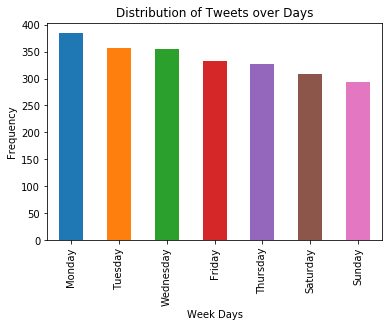

In [63]:
archive_clean.day_name.value_counts().plot('bar')
plt.title("Distribution of Tweets over Days")
plt.xlabel('Week Days')
plt.ylabel('Frequency');

In [247]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
month                   

In [19]:
archive.sample()
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [6]:
# Assess, quality, the ( name ) column is missing some names 
# Assess, quality, there are missing data in these columns: doggo floofer pupper puppo
# Assess, quality, inacurate names in the name column, inaccurate names are used such as a, an, the
# Assess, tidiness, four columns ( doggo	floofer	pupper	puppo) can be replaced with one column (stage) and under it, these four dfferent stages can be specified 

In [64]:
# image data
image_predictions=pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv',sep='\t')

In [65]:
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1157,733482008106668032,https://pbs.twimg.com/media/Ci3Z_idUkAA8RUh.jpg,1,French_bulldog,0.619382,True,computer_keyboard,0.142274,False,mouse,0.058505,False


In [22]:
# I download the file and saved it on Jupyter 

# Here I download from the net, image prediction data from the net, download and save
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

file_name=url.split('/')[-1]
file_name


'image-predictions.tsv'

In [66]:
# image_predictions data info
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
image_predictions_clean=image_predictions.copy()

In [67]:
breed = []
confidence = []

# define the function
def dog_breed_confidence(data):
    if data.p1_dog:
        breed.append(data.p1)
        confidence.append(data.p1_conf)
    elif data.p2_dog:
        breed.append(data.p2)
        confidence.append(data.p2_conf)
    elif data.p3_dog :
        breed.append(data.p3)
        confidence.append(data.p3_conf)
    else:
        breed.append('No breed')
        confidence.append(0)
# apply -row         
image_predictions_clean.apply(dog_breed_confidence,axis =1)
# assign the new column names
image_predictions_clean['dog_breed'] = breed
image_predictions_clean['confidence'] = confidence
# drop the un needed columns now
image_predictions_clean.drop(columns = ['p1', 'p1_dog', 'p1_conf' , 'p2', 'p2_dog',
                                 'p2_conf' , 'p3', 'p3_dog', 'p3_conf'],axis=1, inplace =True)
# rename the No breed values with np.nan
image_predictions_clean.replace('No breed',np.nan, inplace=True)
# replace the underscore with space and title all breeds values
image_predictions_clean.dog_breed= image_predictions_clean.dog_breed.str.replace('_',' ').str.title()

In [395]:
# frequency for dog breeds
image_predictions_clean.dog_breed.value_counts()


Golden Retriever                  173
Labrador Retriever                113
Pembroke                          96 
Chihuahua                         95 
Pug                               65 
Toy Poodle                        52 
Chow                              51 
Samoyed                           46 
Pomeranian                        42 
Malamute                          34 
Cocker Spaniel                    34 
French Bulldog                    32 
Chesapeake Bay Retriever          31 
Miniature Pinscher                26 
Cardigan                          23 
Eskimo Dog                        22 
Staffordshire Bullterrier         22 
German Shepherd                   21 
Beagle                            21 
Siberian Husky                    20 
Shih-Tzu                          20 
Lakeland Terrier                  19 
Maltese Dog                       19 
Rottweiler                        19 
Shetland Sheepdog                 19 
Kuvasz                            19 
Italian Grey

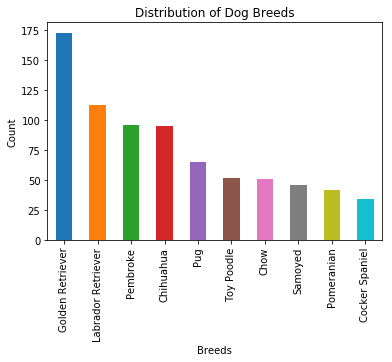

In [68]:
# frequency for dog breeds
image_predictions_clean.dog_breed.value_counts()[:10].plot('bar')
plt.title('Distribution of Dog Breeds')
plt.xlabel('Breeds')
plt.ylabel('Count');

In [20]:
#if not os.path.isfile(file_name):
 #   with open(file_name,'wb') as f:
 #       f.write(r.content)  


In [214]:
# Assess,quality,missing data , colmns have only head titles but without data. For example,column tweet_id, jpg_url, img_num, p1, p1_conf, etc
# Assess, tidiness, many data in the same table, the data need to disributed and put in more tables

In [69]:
# API from thw given files

eman_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        eman_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_eman_now = pd.DataFrame(eman_list)
api_eman_now.sample()

,favorite_count,retweet_count,tweet_id
1256,2308,580,710283270106132480


In [27]:
api_eman_now_clean=api_eman_now.copy()
api_eman_now_clean.sample()

,favorite_count,retweet_count,tweet_id
1303,3835,1490,707387676719185920


In [70]:
#assess programmatically 
api_eman_now.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [71]:
# test, check the tweet_id changed to str(object)
api_eman_now_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [ ]:
# Assess, tidiness, the data can be placed in two tables: one table for tweet_id and retweet_count andthe 
# second table for tweet_id and favorite_count

In [72]:
############# Cleaning Data
### Make a copy of the files before cleaning them to keep the original dataavaiable
archive_clean=archive.copy()


In [370]:
archive_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
932,754011816964026368,NaN,NaN,2016-07-15 17:56:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Charlie. He pouts until he gets to go on the swing. 12/10 manipulative af https://t.co/ilwQqWFKCh,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/754011816964026368/photo/1,https://twitter.com/dog_rates/status/754011816964026368/photo/1",12,10,Charlie,None,None,None,None


In [29]:
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [73]:
# Clean ; quality, keep only the original tweets , eliminate the retweets and the replies, etc.
# assess, there are missing values, the records are NaN, let's drop them
to_drop=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id']
archive_clean.drop(to_drop, inplace=True, axis=1)

In [27]:
archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [31]:
# the text columns have short urls
#clean, quality, split the text colmun and separate the short url
#  by using split method, split the text column into two columns to separate the short url
archive_clean['short_urls'] = archive_clean.text.apply(lambda x :x.strip().split(' ')[-1])
archive_clean.drop('expanded_urls',axis=1,inplace=True)
# split the text column , separate this part `https:` and move it to a column with the same name
archive_clean.text = archive_clean.text.apply(lambda x:x.split('https:')[0])

In [74]:
# test
archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
379,827653905312006145,2017-02-03 23:04:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Boots. She doesn't know what to do with treats so she just holds them. Very good girl. 12/10 would give more treats https://t.co/eAA8lratd3,https://twitter.com/dog_rates/status/827653905312006145/photo/1,12,10,Boots,None,None,None,None


In [32]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'short_urls'],
      dtype='object')

In [79]:
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,short_urls
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,None,None,None,None,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,None,None,None,None,https://t.co/0Xxu71qeIV
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12,10,Archie,None,None,None,None,https://t.co/wUnZnhtVJB
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13,10,Darla,None,None,None,None,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12,10,Franklin,None,None,None,None,https://t.co/AtUZn91f7f
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,13,10,None,None,None,None,None,https://t.co/kQ04fDDRmh
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\n,13,10,Jax,None,None,None,None,https://t.co/tVJBRMnhxl
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10,13,10,None,None,None,None,None,https://t.co/v0nONBcwxq
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek,13,10,Zoey,None,None,None,None,https://t.co/9TwLuAGH0b
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate,14,10,Cassie,doggo,None,None,None,https://t.co/t1bfwz5S2A


In [261]:
# clean, remove the timestamp column, no need for it
#to_drop=['timestamp']
#archive_clean.drop(to_drop,inplace=True,axis=1)

In [75]:
archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitt

In [34]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
short_urls            2356 non-null object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


In [76]:
# clean, tidiness 
# select the dog stages columns from the dataset
dogs_stages = ['doggo', 'floofer', 'pupper', 'puppo']

   
# replace the 'None' string with np.nan 
archive_clean[dogs_stages] = archive_clean[dogs_stages].replace('None', np.nan)

# create the dog_stage column with joining the four columns in one column dog_stage join for more than stage
archive_clean['dog_stage'] =archive_clean[dogs_stages].\
                                        apply(lambda x: ', '.join(x.dropna().astype(str)),axis =1)
# write in the empty string  np.nan and change datatype to category
archive_clean.dog_stage = archive_clean.dog_stage.replace('', np.nan).astype('category')

# drop the 4 columns
archive_clean = archive_clean.drop(columns = dogs_stages, axis =1)

In [36]:
# test
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,short_urls,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://t.co/MgUWQ76dJU,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://t.co/0Xxu71qeIV,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,https://t.co/wUnZnhtVJB,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,https://t.co/tD36da7qLQ,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,https://t.co/AtUZn91f7f,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,None,https://t.co/kQ04fDDRmh,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,https://t.co/tVJBRMnhxl,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,13,10,None,https://t.co/v0nONBcwxq,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,13,10,Zoey,https://t.co/9TwLuAGH0b,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,https://t.co/t1bfwz5S2A,doggo


In [77]:
# count and test
archive_clean.dog_stage.value_counts()

pupper            245
doggo             83 
puppo             29 
doggo, pupper     12 
floofer           9  
doggo, puppo      1  
doggo, floofer    1  
Name: dog_stage, dtype: int64

In [194]:
# clean image_predictions

In [78]:
image_predictions_clean=image_predictions.copy()

In [79]:
### Clean , remove duplicates if any
image_predictions_clean.drop_duplicates(inplace=True)

In [80]:
image_predictions_clean.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
170,668992363537309700,https://pbs.twimg.com/media/CUi9ARGWUAEyWqo.jpg,1,lynx,0.287506,False,tabby,0.206048,False,koala,0.081419,False


In [39]:
# image_pred data info
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 168.2+ KB


In [81]:
# clean , quality , inaccurate records, the rating_numerator has records need to be fixed to 10 (visual assess)
# also, rating_numerator assess programmatically using statistic description of archive
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [41]:
# assess , programmatically  if the denominator values below 10
pd.set_option('display.max_colwidth',-1)
archive.loc[archive.rating_denominator <10 , ['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


In [82]:
# assess programmatically if  rating denominator values > 10 
# if >10 inaccurate records, quality assess
archive.loc[archive.rating_denominator >10 ,['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


In [42]:
# programmatically assess data archive if any rating_numerator <10
archive.loc[archive.rating_numerator < 10,['text','rating_numerator','rating_denominator']]


,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
229,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6,10
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
387,"I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",7,10
462,RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,7,10
485,RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,9,10
599,RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…,8,10
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
730,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
745,RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…,8,10


In [83]:
# Assess ; programatically assess of rating_numerator and rating_denominator revealed somes records are inaccurate and need to be cleaned
# Clean, quality, rating_numerator & rating_denominator:

# make a list of the erros attained by the assess 
indices = [45,2335,1068,1165,1202,1662,695,763,1712]
# and make another list for the correct values relative to the errors obtained in the previous step
vals= [13.5,9,14,13,11,10,9.75,11.27,11.26]
# clean, fix, using for loop and link the two lists, each record with the corresponding value
for i,val in zip(indices,vals):
    archive_clean.loc[i, 'rating_numerator'] = val
    archive_clean.loc[i, 'rating_denominator'] =10
# indez 516 is not entered, clean by drop the index: 516 
archive_clean.drop(index=516,inplace=True)



In [391]:
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,dog_name,short_urls,dog_stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13.0,10,Phineas,https://t.co/MgUWQ76dJU,NaN,39467.0,8853.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13.0,10,Tilly,https://t.co/0Xxu71qeIV,NaN,33819.0,6514.0
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12.0,10,Archie,https://t.co/wUnZnhtVJB,NaN,25461.0,4328.0
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13.0,10,Darla,https://t.co/tD36da7qLQ,NaN,42908.0,8964.0
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12.0,10,Franklin,https://t.co/AtUZn91f7f,NaN,41048.0,9774.0
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,13.0,10,NaN,https://t.co/kQ04fDDRmh,NaN,20562.0,3261.0
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\n,13.0,10,Jax,https://t.co/tVJBRMnhxl,NaN,12041.0,2158.0
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10,13.0,10,NaN,https://t.co/v0nONBcwxq,NaN,56848.0,16716.0
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek,13.0,10,Zoey,https://t.co/9TwLuAGH0b,NaN,28226.0,4429.0
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate,14.0,10,Cassie,https://t.co/t1bfwz5S2A,doggo,32467.0,7711.0


In [84]:
# test 
# check that the inaccurate values of indices are no longer exit, for example use one of these error and wrong entries 
#assert 516 not in list(archive_clean.index)
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2355 non-null int64
timestamp             2355 non-null object
source                2355 non-null object
text                  2355 non-null object
expanded_urls         2296 non-null object
rating_numerator      2355 non-null float64
rating_denominator    2355 non-null int64
name                  2355 non-null object
dog_stage             380 non-null category
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 168.3+ KB


In [85]:
# check for the rating_denominator values
archive_clean.rating_denominator.value_counts()

10     2338
80     2   
50     2   
15     1   
11     1   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
16     1   
0      1   
Name: rating_denominator, dtype: int64

In [ ]:
# assess, dogs name are inaccurate and there are inapproporiate names such as a, an, the, quite
# define , cleaning by renaming the column to dog_name instead of only name, and
# define, cleaning by replace all the inaccurate names to np.nan


In [86]:
# cleaning, rename the name column to dog_name
archive_clean.rename(columns={'name':'dog_name'},inplace=True)
# converted lower names to np.nan
lowers = archive_clean.dog_name.str.islower()
archive_clean.loc[lowers,'dog_name'] = 'None'
# make all values titled
archive_clean.dog_name = archive_clean.dog_name.apply(lambda x: x.title())
# relace 'None' with np.nan values
archive_clean.dog_name.replace('None', np.nan, inplace= True)

In [87]:
archive_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage
661,791026214425268224,2016-10-25 21:18:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Alfie. He's touching a butt. Couldn't be happier. 11/10 https://t.co/gx3xF5mZbo,"https://twitter.com/dog_rates/status/763837565564780549/photo/1,https://twitter.com/dog_rates/status/763837565564780549/photo/1",11.0,10,Alfie,NaN


In [88]:
api_eman_now_clean=api_eman_now.copy()

In [95]:
# tidiness
# we tackle the tweets over three datasets, combine them in a master dataeset
archive_clean = pd.merge(archive_clean, api_eman_now_clean , how = 'left' , on = 'tweet_id')

# use the merge function to merge `twitter_archive_clean` and `image_pred_clean` on tweet_id column (inner join) 
# and make master dataset
master_dataset = pd.merge(archive_clean, image_predictions_clean , how = 'inner' , on = 'tweet_id')

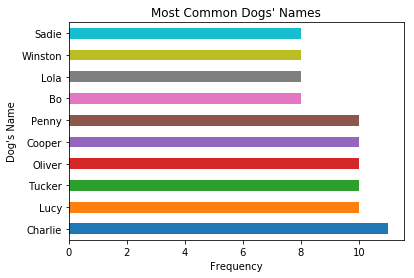

In [98]:
# Visualize data 
# rank the names 
master_dataset.dog_name.value_counts().sort_values(ascending =False)[:10].plot('barh')
plt.title("Most Common Dogs' Names")
plt.xlabel('Frequency')
plt.ylabel("Dog's Name");

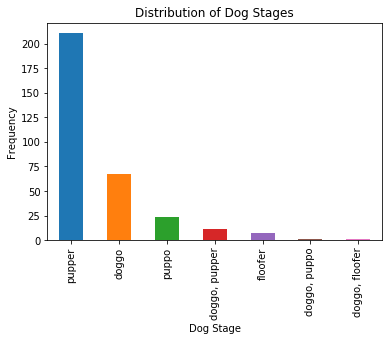

In [91]:
# select the dog_ stage frequencies
master_dataset.dog_stage.value_counts().plot('bar')
plt.title("Distribution of Dog Stages")
plt.xlabel('Dog Stage')
plt.ylabel('Frequency');

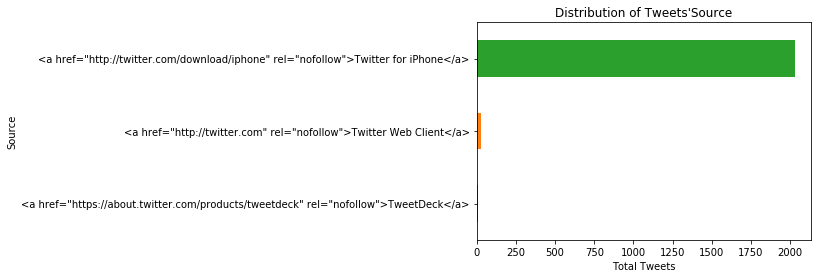

In [97]:
plt.title("Distribution of Tweets'Source")
master_dataset.source.value_counts().sort_values().plot(kind ='barh')
plt.xlabel('Total Tweets')
plt.ylabel('Source');